In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### Loading All Required Libraries

In [2]:
import numpy as np
import pandas as pd
from random import sample
from numpy.random import uniform
from math import isnan

#for hopkins statistics
from sklearn.neighbors import NearestNeighbors

# Library for Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Library for Scaling
from sklearn.preprocessing import StandardScaler

#Library for Modeling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#Library for creating Hierarchical Clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

#for split the dataset for training purpose
from sklearn.model_selection import train_test_split

# For evaluation purpose
from sklearn import metrics
from sklearn.metrics import silhouette_score

#For prediction purpose
from sklearn.linear_model import LogisticRegression

In [3]:
sns.set_style("white")
%matplotlib inline

### Some Important Functions

In [4]:
#get hopkins score
def hopkins(X):
    d = X.shape[1]

    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),
                                            np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [5]:
#get hotencoded list of all categories for a given field. 
#If there is Nan in the field then it is listed first
#df name of dataframe, fld- name of cat field for which cat need to be extracted, 
#hasNull- whether field can have null value or no

def getValuesForCat(df, fld, hasNull=True):
    lst = list(df[fld].unique())

    if hasNull:
        lst.remove(np.nan)
        lst.insert(0,np.nan)
    print (lst,"\n")
    print ( np.array(range(len(lst))), "\n")
    return df[fld].apply(lambda x: lst.index(x))

In [6]:
#List of All Numerical Fields
def getNumFields(df):
    return df.columns [ ~ (df.dtypes=='object') ]

### Understanding Dataset

In [7]:
df_lead = pd.read_csv("Leads.csv")

In [8]:
df_lead.shape

(9240, 37)

In [9]:
df_lead.head(1)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified


In [10]:
#Converted Lead %
Old_Conversion_Rate = round(len(df_lead.Converted[ df_lead.Converted==1])/len(df_lead)*100,0)
print (Old_Conversion_Rate, "%")

39.0 %


In [11]:
# Check Null values in any column, dtype in dataset
df=pd.DataFrame( {"Null %": round(df_lead.isna().sum(axis=0)/len(df_lead)*100,2),
                  "Field Type": df_lead.dtypes} ) 
df

,Null %,Field Type
Prospect ID,0.00,object
Lead Number,0.00,int64
Lead Origin,0.00,object
Lead Source,0.39,object
Do Not Email,0.00,object
Do Not Call,0.00,object
Converted,0.00,int64
TotalVisits,1.48,float64
Total Time Spent on Website,0.00,int64
Page Views Per Visit,1.48,float64


#### Idetify Duplicate Information Column

In [12]:
print (len(df_lead['Prospect ID'].unique()))
print (len(df_lead['Lead Number'].unique()))

#Drop the "Prospect ID" it is duplicate and of no value.
df_lead =df_lead.drop(columns=["Prospect ID"], axis=0)

9240
9240


In [13]:
#Make a copy of dataset before null value treatment
df_lead_org=df_lead.copy()

### Null Value Handling for Numerical Fields

In [14]:
#num_flds1 containts all numeric fields in out Dataset
num_flds1 = list( getNumFields(df_lead) )

#num_flds2 containts those fields which need to be scaled
num_flds2=num_flds1.copy()
num_flds2.remove("Lead Number")
num_flds2.remove("Converted")

#num_flds containts those fields which need to be scaled in first round
num_flds=num_flds2.copy()
num_flds.remove("Asymmetrique Activity Score")
num_flds.remove("Asymmetrique Profile Score")
#Above 2 score fields are not being scaled in first round because they depends upon index
#so if we impute corresponding index fields first then then impute score based on the index 
#that will be the better way.

In [15]:
print (num_flds1)
print (num_flds2)
print (num_flds)

['Lead Number', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']


In [16]:
df_lead[num_flds].describe()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9103.000000,9240.000000,9103.000000
mean,3.445238,487.698268,2.362820
std,4.854853,548.021466,2.161418
min,0.000000,0.000000,0.000000
25%,1.000000,12.000000,1.000000
50%,3.000000,248.000000,2.000000
75%,5.000000,936.000000,3.000000
max,251.000000,2272.000000,55.000000


In [17]:
#Null values in numeric fields (which we will scaled first)
df_lead[num_flds].isna().sum()/len(df_lead[num_flds])*100

TotalVisits                    1.482684
Total Time Spent on Website    0.000000
Page Views Per Visit           1.482684
dtype: float64

In [18]:
f='TotalVisits'
df_lead[f].unique()

array([  0.,   5.,   2.,   1.,   4.,   8.,  11.,   6.,   3.,   7.,  13.,
        17.,  nan,   9.,  12.,  10.,  16.,  14.,  21.,  15.,  22.,  19.,
        18.,  20.,  43.,  30.,  23.,  55., 141.,  25.,  27.,  29.,  24.,
        28.,  26.,  74.,  41.,  54., 115., 251.,  32.,  42.])

In [19]:
#Impute TotalVisits Null Values with Mean
print ("Mean value for", f, int(df_lead[f].mean()))
df_lead[f] [ df_lead[f].isna()] = int(df_lead[f].mean())

Mean value for TotalVisits 3


In [20]:
f='Page Views Per Visit'
df_lead[f].unique()

array([ 0.  ,  2.5 ,  2.  ,  1.  ,  4.  ,  8.  ,  2.67, 11.  ,  5.  ,
        6.  ,  3.  ,  1.33,  1.5 ,  3.5 ,  7.  ,  2.33, 13.  ,  8.5 ,
        5.5 ,  1.67,   nan,  4.5 ,  3.33, 16.  , 12.  ,  1.71,  1.8 ,
        6.5 ,  4.33, 14.  ,  3.4 , 10.  ,  1.25,  1.75,  2.63, 15.  ,
        2.25,  3.67,  1.43,  9.  ,  2.6 ,  4.75,  1.27,  3.25,  5.33,
        2.57,  2.17,  2.75,  2.8 ,  2.2 ,  2.86,  3.91,  1.4 ,  5.67,
        3.2 ,  1.38,  2.09,  2.4 , 55.  ,  5.25,  6.71,  3.57,  2.22,
        1.83,  3.6 ,  1.2 ,  1.57,  1.56,  5.4 ,  4.25,  1.31,  1.6 ,
        2.9 ,  1.23,  1.78,  3.83,  7.5 ,  1.14,  2.71,  1.45,  2.38,
        1.86,  2.29,  1.21, 12.33,  3.43,  2.56,  6.33,  1.64,  8.21,
        4.4 ,  3.17,  8.33,  1.48,  1.22, 24.  ,  3.75,  6.67,  1.54,
        2.13,  2.14,  2.45,  3.29,  4.17,  1.63,  3.38,  1.17, 14.5 ,
        3.8 ,  1.19,  3.82,  2.83,  1.93, 11.5 ,  2.08])

In [21]:
#Impute 'Page Views Per Visit' Null Values with Mean
print ("Mean value for", f, round(df_lead[f].mean(),2))
df_lead[f] [ df_lead[f].isna()] = round(df_lead[f].mean(),2)

Mean value for Page Views Per Visit 2.36


In [22]:
#df_lead_p1  will be used in future steps to extract the below fields
f=['Lead Number','Converted','Asymmetrique Activity Score','Asymmetrique Profile Score']
df_lead_p1=df_lead[f]

#drop above identified fields from the dataset as they should NOT be scaled
df_lead.drop(columns=f,inplace=True)

In [23]:
#Null values in numeric fields. There is no null value in identified numeric fields.
df_lead[num_flds].isna().sum()/len(df_lead)*100

TotalVisits                    0.0
Total Time Spent on Website    0.0
Page Views Per Visit           0.0
dtype: float64

In [24]:
print ("Number of fields in dataset ", df_lead.shape[1])

Number of fields in dataset  32


### Cleaning Categorical Variables

In [25]:
#This function returns the list of All Categorical Fields in dataset format.
#df - Name of the dataframe, WithOneValue- If you want those cat fields which has 99+ same information in the field
#NullValueFields- If we want only those fields which have null values - pass "Yes", 
#If we want only those fields which has no null values- Pass "No",
#if we want all the fields then pass "All"
def getCatFields(df, WithOneValue=False, NullValueFields="All"):
    object_flds=df.columns [ df.dtypes=='object']


    #Name of Categorical Variable, Mode of Categorical variable, # of Categories, % of Mode Category
    flds=[]
    for o in object_flds:
        flds.append ( [ o,                         
                        len(df[o].astype("category").value_counts()),
                        df[o].astype("category").value_counts().index[0],
                        round(max(df[o].astype("category").value_counts()/len(df))*100,2),
                        round(df[o].isna().sum()/len(df)*100,2)
                      ] )
    flds.sort()

    df1 = pd.DataFrame( flds, columns=["Categorical_FieldName",
                                       "# of Categories",
                                       "Mode_of_Category_Field",
                                       "Percent_of_Mode",
                                       "Null%"] )
    if WithOneValue:
        df1 = df1[ df1.Percent_of_Mode>99]
    
    if NullValueFields=="Yes":
        df1 = df1[ df1["Null%"]>0]
    elif NullValueFields=="No":
        df1 = df1[ df1["Null%"]==0]
        
    return df1


#### Handle Columns which has same  information for all the records

In [26]:
#Identify all the fields in dataset which has 99+ % same information in the columns
df_temp= getCatFields(df_lead, WithOneValue=True)
df_temp

,Categorical_FieldName,# of Categories,Mode_of_Category_Field,Percent_of_Mode,Null%
5,Digital Advertisement,2,No,99.96,0.0
6,Do Not Call,2,No,99.98,0.0
8,Get updates on DM Content,1,No,100.00,0.0
10,I agree to pay the amount through cheque,1,No,100.00,0.0
17,Magazine,1,No,100.00,0.0
18,Newspaper,2,No,99.99,0.0
19,Newspaper Article,2,No,99.98,0.0
20,Receive More Updates About Our Courses,1,No,100.00,0.0
21,Search,2,No,99.85,0.0
24,Through Recommendations,2,No,99.92,0.0


In [27]:
#drop these columns which has same information for all the records
fld= list(df_temp.Categorical_FieldName)
df_lead = df_lead.drop(columns=fld)
print ("Number of fields dropped", len(fld))
print ("Number of fields in dataset ", df_lead.shape[1])

Number of fields dropped 12
Number of fields in dataset  20


In [28]:
df_lead.head(5)

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,Interested in other courses,Low in Relevance,Select,Select,02.Medium,02.Medium,No,Modified
1,API,Organic Search,No,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,Ringing,NaN,Select,Select,02.Medium,02.Medium,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,Will revert after reading the email,Might be,Potential Lead,Mumbai,02.Medium,01.High,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,Ringing,Not Sure,Select,Mumbai,02.Medium,01.High,No,Modified
4,Landing Page Submission,Google,No,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,Will revert after reading the email,Might be,Select,Mumbai,02.Medium,01.High,No,Modified


In [29]:
#After drop above fields, list of categorical fields, with % of null values, number of categories in each field, 
#Mode of each categorical field and % of that mode in that column
#For example "City" fields has 7 cities, 15% null values, Mumbai is Mode of this field and 35% values 
#in City colum is Mumbai

df_temp= getCatFields(df_lead, False)
df_temp

,Categorical_FieldName,# of Categories,Mode_of_Category_Field,Percent_of_Mode,Null%
0,A free copy of Mastering The Interview,2,No,68.74,0.00
1,Asymmetrique Activity Index,3,02.Medium,41.55,45.65
2,Asymmetrique Profile Index,3,02.Medium,30.17,45.65
3,City,7,Mumbai,34.87,15.37
4,Country,38,India,70.26,26.63
5,Do Not Email,2,No,92.06,0.00
6,How did you hear about X Education,10,Select,54.58,23.89
7,Last Activity,17,Email Opened,37.20,1.11
8,Last Notable Activity,16,Modified,36.87,0.00
9,Lead Origin,5,Landing Page Submission,52.88,0.00


### Handling "Select" value in categorical field

In [30]:
#Replace all "Select" with np.nan

In [31]:
#Identify those categorical columns which has "Select" as a category
sel_val_fields=[]
flds = df_lead[ df_temp.Categorical_FieldName]
for f in flds:
    if len( df_lead[ f ] [df_lead[ f ]=="Select" ] )>0:    
        sel_val_fields.append(f)
        
print (sel_val_fields)        

#Replace "Select" with np.nan in those categorical fields
for f in sel_val_fields:
    df_lead[f][ df_lead[f]=="Select" ]=np.nan

['City', 'How did you hear about X Education', 'Lead Profile', 'Specialization']


In [32]:
#After replacing Select with Nan, check again % of Null values in Categorical fields
df_temp= getCatFields(df_lead, False)
df_temp

,Categorical_FieldName,# of Categories,Mode_of_Category_Field,Percent_of_Mode,Null%
0,A free copy of Mastering The Interview,2,No,68.74,0.00
1,Asymmetrique Activity Index,3,02.Medium,41.55,45.65
2,Asymmetrique Profile Index,3,02.Medium,30.17,45.65
3,City,6,Mumbai,34.87,39.71
4,Country,38,India,70.26,26.63
5,Do Not Email,2,No,92.06,0.00
6,How did you hear about X Education,9,Online Search,8.74,78.46
7,Last Activity,17,Email Opened,37.20,1.11
8,Last Notable Activity,16,Modified,36.87,0.00
9,Lead Origin,5,Landing Page Submission,52.88,0.00


### Null Value Handling

In [33]:
#Get No Null Value Categorical Fields
df_temp= getCatFields(df_lead, WithOneValue=False, NullValueFields="No")
df_temp

,Categorical_FieldName,# of Categories,Mode_of_Category_Field,Percent_of_Mode,Null%
0,A free copy of Mastering The Interview,2,No,68.74,0.0
5,Do Not Email,2,No,92.06,0.0
8,Last Notable Activity,16,Modified,36.87,0.0
9,Lead Origin,5,Landing Page Submission,52.88,0.0


In [34]:
#Get Categorical Fields which has Null Values
df_temp= getCatFields(df_lead, WithOneValue=False, NullValueFields="Yes")
df_temp

,Categorical_FieldName,# of Categories,Mode_of_Category_Field,Percent_of_Mode,Null%
1,Asymmetrique Activity Index,3,02.Medium,41.55,45.65
2,Asymmetrique Profile Index,3,02.Medium,30.17,45.65
3,City,6,Mumbai,34.87,39.71
4,Country,38,India,70.26,26.63
6,How did you hear about X Education,9,Online Search,8.74,78.46
7,Last Activity,17,Email Opened,37.20,1.11
10,Lead Profile,5,Potential Lead,17.46,74.19
11,Lead Quality,5,Might be,16.88,51.59
12,Lead Source,21,Google,31.04,0.39
13,Specialization,18,Finance Management,10.56,36.58


In [35]:
#List all Categorical Variables with Null Values and categories
flds = df_lead[ df_temp.Categorical_FieldName]
for f in flds:
    if round(df_lead[ f ].isna().sum(axis=0)/len(df_lead)*100,2)!=0:
        print ( "Null ",round(df_lead[ f ].isna().sum(axis=0)/len(df_lead)*100,2) )
        print ( round( df_lead[ f ].astype('category').value_counts()/len(df_lead)*100 ,2))
        print ( "\n" )

        

Null  45.65
02.Medium    41.55
01.High       8.89
03.Low        3.92
Name: Asymmetrique Activity Index, dtype: float64


Null  45.65
02.Medium    30.17
01.High      23.84
03.Low        0.34
Name: Asymmetrique Profile Index, dtype: float64


Null  39.71
Mumbai                         34.87
Thane & Outskirts               8.14
Other Cities                    7.42
Other Cities of Maharashtra     4.95
Other Metro Cities              4.11
Tier II Cities                  0.80
Name: City, dtype: float64


Null  26.63
India                   70.26
United States            0.75
United Arab Emirates     0.57
Singapore                0.26
Saudi Arabia             0.23
United Kingdom           0.16
Australia                0.14
Qatar                    0.11
Hong Kong                0.08
Bahrain                  0.08
Oman                     0.06
France                   0.06
unknown                  0.05
South Africa             0.04
Canada                   0.04
Nigeria                  0.04
Germ

#### Null Treatment using Mode value

In [36]:
#Null Treatment for "Lead Source"
#Null  0.39
#Google               31.04
#Direct Traffic       27.52
#Olark Chat           18.99
#Organic Search       12.49
#Reference             5.78
#Welingak Website      1.54
#Referral Sites        1.35
#Facebook              0.60
#bing                  0.06
#google                0.05
#Click2call            0.04
#Press_Release         0.02
#Social Media          0.02
#Live Chat             0.02
#Pay per Click Ads     0.01
#welearnblog_Home      0.01
#NC_EDM                0.01
#WeLearn               0.01
#blog                  0.01
#testone               0.01
#youtubechannel        0.01

df_lead["Lead Source"] [df_lead["Lead Source"].isna()] = "Google"

In [37]:
#Null Treatment for "Last Activity"
#Null  1.11
#Email Opened                    37.20
#SMS Sent                        29.71
#Olark Chat Conversation         10.53
#Page Visited on Website          6.93
#Converted to Lead                4.63
#Email Bounced                    3.53
#Email Link Clicked               2.89
#Form Submitted on Website        1.26
#Unreachable                      1.01
#Unsubscribed                     0.66
#Had a Phone Conversation         0.32
#Approached upfront               0.10
#View in browser link Clicked     0.06
#Email Marked Spam                0.02
#Email Received                   0.02
#Resubscribed to emails           0.01
#Visited Booth in Tradeshow       0.01

df_lead["Last Activity"] [df_lead["Last Activity"].isna()] = "Email Opened"

In [38]:
#Null Treatment for "What matters most to you in choosing a course"
#Action: Drop the column

#Null  29.32
#Better Career Prospects      71.65
#Flexibility & Convenience     0.02
#Other                         0.01
df_lead.drop(columns=["What matters most to you in choosing a course"], inplace=True)

In [39]:
print ("Number of fields in dataset :", df_lead.shape[1])

Number of fields in dataset : 19


In [40]:
#Get Categorical Fields which has No-Null Values
df_temp= getCatFields(df_lead, WithOneValue=False, NullValueFields="No")
df_temp

,Categorical_FieldName,# of Categories,Mode_of_Category_Field,Percent_of_Mode,Null%
0,A free copy of Mastering The Interview,2,No,68.74,0.0
5,Do Not Email,2,No,92.06,0.0
7,Last Activity,17,Email Opened,38.31,0.0
8,Last Notable Activity,16,Modified,36.87,0.0
9,Lead Origin,5,Landing Page Submission,52.88,0.0
12,Lead Source,21,Google,31.43,0.0


In [41]:
#After treating null values with mode
#Get Categorical Fields which still has Null Values
df_temp= getCatFields(df_lead, WithOneValue=False, NullValueFields="Yes")
df_temp

,Categorical_FieldName,# of Categories,Mode_of_Category_Field,Percent_of_Mode,Null%
1,Asymmetrique Activity Index,3,02.Medium,41.55,45.65
2,Asymmetrique Profile Index,3,02.Medium,30.17,45.65
3,City,6,Mumbai,34.87,39.71
4,Country,38,India,70.26,26.63
6,How did you hear about X Education,9,Online Search,8.74,78.46
10,Lead Profile,5,Potential Lead,17.46,74.19
11,Lead Quality,5,Might be,16.88,51.59
13,Specialization,18,Finance Management,10.56,36.58
14,Tags,26,Will revert after reading the email,22.42,36.29
15,What is your current occupation,6,Unemployed,60.61,29.11


#### Scale the numberic values of Dataset

In [42]:
sc= StandardScaler()
df_lead_scaled = df_lead.copy()
df_lead_scaled[num_flds] = pd.DataFrame( sc.fit_transform( df_lead_scaled [num_flds]), columns=num_flds)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [43]:
df_lead_scaled.shape

(9240, 19)

#### Prepare for Hotencoding of Categorical Fields

In [44]:
#Lead Dataset with columns which Doest not have any null values
df_wo_null= df_lead.loc[::,list(df_lead.isna().sum()==0)]

#Lead Dataset with columns which has null values
df_with_null = df_lead.loc[::,list(df_lead.isna().sum()>0)]

In [45]:
df_wo_null.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [46]:
df_with_null.columns

Index(['Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation', 'Tags', 'Lead Quality',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index'],
      dtype='object')

In [47]:
#Scaled Dataset of only those columns which does not have any null Value
df_lead_noNulCol_sc= df_lead_scaled.loc[::,list(df_lead_scaled.isna().sum()==0)]


In [48]:
#List of Categorical variables which does not have null values
catflds = list( getCatFields(df_lead_noNulCol_sc).Categorical_FieldName )
catflds

['A free copy of Mastering The Interview',
 'Do Not Email',
 'Last Activity',
 'Last Notable Activity',
 'Lead Origin',
 'Lead Source']

In [49]:
df_lead_noNulCol_sc.head()

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,-0.713593,-0.889974,-1.101417,Page Visited on Website,No,Modified
1,API,Organic Search,No,0.324018,0.339972,0.063966,Email Opened,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,-0.298549,1.905689,-0.169110,Email Opened,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,-0.506071,-0.333396,-0.635264,Unreachable,No,Modified
4,Landing Page Submission,Google,No,-0.298549,1.715905,-0.635264,Converted to Lead,No,Modified


#### Numerical encoding of Categorical Fields

In [50]:
df_lead_noNulCol_sc['Lead Origin']=getValuesForCat(df_lead_noNulCol_sc,'Lead Origin',False)

['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import', 'Quick Add Form'] 

[0 1 2 3 4] 



In [51]:
df_lead_noNulCol_sc['Lead Source']=getValuesForCat(df_lead_noNulCol_sc,'Lead Source',False)

['Olark Chat', 'Organic Search', 'Direct Traffic', 'Google', 'Referral Sites', 'Welingak Website', 'Reference', 'google', 'Facebook', 'blog', 'Pay per Click Ads', 'bing', 'Social Media', 'WeLearn', 'Click2call', 'Live Chat', 'welearnblog_Home', 'youtubechannel', 'testone', 'Press_Release', 'NC_EDM'] 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 



In [52]:
df_lead_noNulCol_sc['Do Not Email']=getValuesForCat(df_lead_noNulCol_sc,'Do Not Email',False)

['No', 'Yes'] 

[0 1] 



In [53]:
df_lead_noNulCol_sc['Last Activity']=getValuesForCat(df_lead_noNulCol_sc,'Last Activity',False)

['Page Visited on Website', 'Email Opened', 'Unreachable', 'Converted to Lead', 'Olark Chat Conversation', 'Email Bounced', 'Email Link Clicked', 'Form Submitted on Website', 'Unsubscribed', 'Had a Phone Conversation', 'View in browser link Clicked', 'Approached upfront', 'SMS Sent', 'Visited Booth in Tradeshow', 'Resubscribed to emails', 'Email Received', 'Email Marked Spam'] 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 



In [54]:
df_lead_noNulCol_sc['A free copy of Mastering The Interview']=getValuesForCat(df_lead_noNulCol_sc,'A free copy of Mastering The Interview',False)

['No', 'Yes'] 

[0 1] 



In [55]:
df_lead_noNulCol_sc['Last Notable Activity']=getValuesForCat(df_lead_noNulCol_sc,'Last Notable Activity',False)

['Modified', 'Email Opened', 'Page Visited on Website', 'Email Bounced', 'Email Link Clicked', 'Unreachable', 'Unsubscribed', 'Had a Phone Conversation', 'Olark Chat Conversation', 'SMS Sent', 'Approached upfront', 'Resubscribed to emails', 'View in browser link Clicked', 'Form Submitted on Website', 'Email Received', 'Email Marked Spam'] 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 



In [56]:
df_lead_noNulCol_sc.head()

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,A free copy of Mastering The Interview,Last Notable Activity
0,0,0,0,-0.713593,-0.889974,-1.101417,0,0,0
1,0,1,0,0.324018,0.339972,0.063966,1,0,1
2,1,2,0,-0.298549,1.905689,-0.169110,1,1,1
3,1,2,0,-0.506071,-0.333396,-0.635264,2,0,0
4,1,3,0,-0.298549,1.715905,-0.635264,3,0,0


In [57]:
#Saving this encoded information of cat fields in df_lead_p1
f= ['Lead Origin','Lead Source','Do Not Email','Last Activity',
                    'A free copy of Mastering The Interview','Last Notable Activity']

df_lead_p1[f] = df_lead_noNulCol_sc[f]

In [58]:
catflds

['A free copy of Mastering The Interview',
 'Do Not Email',
 'Last Activity',
 'Last Notable Activity',
 'Lead Origin',
 'Lead Source']

In [59]:
#Create Dummy Variables for these Fields
cat1 = pd.get_dummies(df_lead_noNulCol_sc[ catflds[0] ] , prefix="freeCopy", drop_first=True)
cat2 = pd.get_dummies(df_lead_noNulCol_sc[ catflds[1] ] , prefix="NoEmail", drop_first=True)
cat3 = pd.get_dummies(df_lead_noNulCol_sc[ catflds[2] ] , prefix="LastAct", drop_first=True)
cat4 = pd.get_dummies(df_lead_noNulCol_sc[ catflds[2] ] , prefix="NotableAct", drop_first=True)
cat5 = pd.get_dummies(df_lead_noNulCol_sc[ catflds[3] ] , prefix="LeadOrg", drop_first=True)
cat6 = pd.get_dummies(df_lead_noNulCol_sc[ catflds[4] ] , prefix="LeadSrc", drop_first=True)

#drop Original columns from df_final
df_lead_noNulCol_sc.drop(columns=catflds, inplace=True)

#concatenate all the dummy variables with main dataset
df_lead_noNulCol_sc = pd.concat( [df_lead_noNulCol_sc,cat1,cat2,cat3,cat4,cat5,cat6], axis=1)

#This dataset of leads has following properties: Scaled, No-Null value Column, Contain Dummy Variables

In [60]:
cols=list(df_lead_noNulCol_sc.columns)
#cols

In [61]:
#List of columns which does not have any null values
# df_lead_noNulCol_sc.isna().sum()

## Categorical Values Null Value Treatment

###### Logistic Regression

In [62]:
# Now we need to Treat Null Values of following columns
df_with_null.columns

Index(['Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation', 'Tags', 'Lead Quality',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index'],
      dtype='object')

In [63]:
#Impute Null Categorical Values
def imputeNull_CatValues(df,fld):
    # Get hotencoded categories for a given field, create a new field in main dataframe and assign this to that field    
    df[fld] = getValuesForCat(df_with_null,fld,True)

    #create train dataset from main dataframe, it includes only non null rows of the given field
    #(in hotencoding process null is converted to 0)
    col =cols.copy()
    
    #create test dataset from main dataframe, it includes all the rows.
    X_test = df[col]
    
    col.append(fld)    
    df_train = df[col] [ df[fld]!=0]  

    #supplied fld in dataframe need to be classified. So we need to train using this field
    y_train= df_train[fld]
    X_train = df_train.drop(columns=fld)

    #Training the model on the train data
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression()

    lm = lr.fit(X_train,y_train)

    #predict using train data
    pred_train_clusterid = lm.predict(X_train)

    #predict using test data
    pred_test_clusterid = lm.predict(X_test)

    print ("Accuracy on Train Dataset :",
    round(metrics.accuracy_score(y_train, pred_train_clusterid),2))
    
    df1 = pd.DataFrame( {"prediction":pred_test_clusterid, "actual":df[fld]})
    
    #create a need field in temp dataframe df1, 
    #for a given field if actual==0 (it has null value) then use prediction to replace
    df1.loc[ df1["actual"]==0,fld] = df1["prediction"]
    
    #If actual is not null then we should not use predicted cluster value, so use actual value
    df1.loc[ df1["actual"]!=0,fld] = df1["actual"]
    
    #ensure filed is integer
    df1[fld] = df1[fld].apply(int)
    
    #replace this column from temp df1 to main dataframe df
    df[fld] = df1[fld]
    
    #With this all null values for given field in the dataframe has been replace with the predicted value
    
    return

In [64]:
df=df_lead_noNulCol_sc

In [65]:
imputeNull_CatValues(df,"Country")

[nan, 'India', 'Russia', 'Kuwait', 'Oman', 'United Arab Emirates', 'United States', 'Australia', 'United Kingdom', 'Bahrain', 'Ghana', 'Singapore', 'Qatar', 'Saudi Arabia', 'Belgium', 'France', 'Sri Lanka', 'China', 'Canada', 'Netherlands', 'Sweden', 'Nigeria', 'Hong Kong', 'Germany', 'Asia/Pacific Region', 'Uganda', 'Kenya', 'Italy', 'South Africa', 'Tanzania', 'unknown', 'Malaysia', 'Liberia', 'Switzerland', 'Denmark', 'Philippines', 'Bangladesh', 'Vietnam', 'Indonesia'] 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38] 

Accuracy on Train Dataset : 0.96


In [66]:
imputeNull_CatValues(df,"Specialization")

[nan, 'Business Administration', 'Media and Advertising', 'Supply Chain Management', 'IT Projects Management', 'Finance Management', 'Travel and Tourism', 'Human Resource Management', 'Marketing Management', 'Banking, Investment And Insurance', 'International Business', 'E-COMMERCE', 'Operations Management', 'Retail Management', 'Services Excellence', 'Hospitality Management', 'Rural and Agribusiness', 'Healthcare Management', 'E-Business'] 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 

Accuracy on Train Dataset : 0.19


In [67]:
imputeNull_CatValues(df,"How did you hear about X Education")

[nan, 'Word Of Mouth', 'Other', 'Online Search', 'Multiple Sources', 'Advertisements', 'Student of SomeSchool', 'Email', 'Social Media', 'SMS'] 

[0 1 2 3 4 5 6 7 8 9] 

Accuracy on Train Dataset : 0.41


In [68]:
imputeNull_CatValues(df,"What is your current occupation")

[nan, 'Unemployed', 'Student', 'Working Professional', 'Businessman', 'Other', 'Housewife'] 

[0 1 2 3 4 5 6] 

Accuracy on Train Dataset : 0.86


In [69]:
imputeNull_CatValues(df,"Tags")

[nan, 'Interested in other courses', 'Ringing', 'Will revert after reading the email', 'Lost to EINS', 'In confusion whether part time or DLP', 'Busy', 'switched off', 'in touch with EINS', 'Already a student', 'Diploma holder (Not Eligible)', 'Graduation in progress', 'Closed by Horizzon', 'number not provided', 'opp hangup', 'Not doing further education', 'invalid number', 'wrong number given', 'Interested  in full time MBA', 'Still Thinking', 'Lost to Others', 'Shall take in the next coming month', 'Lateral student', 'Interested in Next batch', 'Recognition issue (DEC approval)', 'Want to take admission but has financial problems', 'University not recognized'] 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] 

Accuracy on Train Dataset : 0.47


In [70]:
imputeNull_CatValues(df,"Lead Quality")

[nan, 'Low in Relevance', 'Might be', 'Not Sure', 'Worst', 'High in Relevance'] 

[0 1 2 3 4 5] 

Accuracy on Train Dataset : 0.46


In [71]:
imputeNull_CatValues(df,"Lead Profile")

[nan, 'Potential Lead', 'Other Leads', 'Lateral Student', 'Dual Specialization Student', 'Student of SomeSchool'] 

[0 1 2 3 4 5] 

Accuracy on Train Dataset : 0.69


In [72]:
imputeNull_CatValues(df,"City")

[nan, 'Mumbai', 'Thane & Outskirts', 'Other Metro Cities', 'Other Cities', 'Other Cities of Maharashtra', 'Tier II Cities'] 

[0 1 2 3 4 5 6] 

Accuracy on Train Dataset : 0.58


In [73]:
imputeNull_CatValues(df,"Asymmetrique Activity Index")

[nan, '02.Medium', '01.High', '03.Low'] 

[0 1 2 3] 

Accuracy on Train Dataset : 0.79


In [74]:
imputeNull_CatValues(df,"Asymmetrique Profile Index")

[nan, '02.Medium', '01.High', '03.Low'] 

[0 1 2 3] 

Accuracy on Train Dataset : 0.81


#### Imputing Numeric Fields with the help of related Categorical Field

In [75]:
#'Asymmetrique Activity Index' & 'Asymmetrique Activity Score'
#'Asymmetrique Profile Index'& 'Asymmetrique Profile Score' are related fields 
#after we have imputed Index, with the helpf of index we can impute the score 
#with average score of non-null of the same index

In [76]:
f=['Asymmetrique Activity Score','Asymmetrique Profile Score']
df_lead_noNulCol_sc[f] =df_lead_p1[f]


In [77]:
#For the index of High, Medium, Low get the score 
f1='Asymmetrique Activity Index'
f2='Asymmetrique Activity Score'
high1= round(df_lead_noNulCol_sc[f2] [ df_lead_noNulCol_sc[f1]==2].mean(),0)
med1= round(df_lead_noNulCol_sc[f2] [ df_lead_noNulCol_sc[f1]==1].mean(),0)
low1 = round(df_lead_noNulCol_sc[f2] [ df_lead_noNulCol_sc[f1]==3].mean(),0)
print (high1, med1,low1)

f1='Asymmetrique Profile Index'
f2='Asymmetrique Profile Score'
high2= round(df_lead_noNulCol_sc[f2] [ df_lead_noNulCol_sc[f1]==2].mean(),0)
med2= round(df_lead_noNulCol_sc[f2] [ df_lead_noNulCol_sc[f1]==1].mean(),0)
low2 = round(df_lead_noNulCol_sc[f2] [ df_lead_noNulCol_sc[f1]==3].mean(),0)
print (high2, med2,low2)

16.0 14.0 11.0
18.0 15.0 12.0


In [78]:
#Impute the scores
f1='Asymmetrique Activity Index'
f2='Asymmetrique Activity Score'
df_lead_noNulCol_sc[f2] [ (df_lead_noNulCol_sc[f1]==2) & (df_lead_noNulCol_sc[f2].isna() )] = high1
df_lead_noNulCol_sc[f2] [ (df_lead_noNulCol_sc[f1]==1) & (df_lead_noNulCol_sc[f2].isna() )] = med1
df_lead_noNulCol_sc[f2] [ (df_lead_noNulCol_sc[f1]==3) & (df_lead_noNulCol_sc[f2].isna() )] = low1


f1='Asymmetrique Profile Index'
f2='Asymmetrique Profile Score'
df_lead_noNulCol_sc[f2] [ (df_lead_noNulCol_sc[f1]==2) & (df_lead_noNulCol_sc[f2].isna() )] = high2
df_lead_noNulCol_sc[f2] [ (df_lead_noNulCol_sc[f1]==1) & (df_lead_noNulCol_sc[f2].isna() )] = med2
df_lead_noNulCol_sc[f2] [ (df_lead_noNulCol_sc[f1]==3) & (df_lead_noNulCol_sc[f2].isna() )] = low2


In [79]:
#Null cat fields has been treated and now put back these fields in df_lead_p1 dataset
df_lead_p1[df_with_null.columns] = df_lead_noNulCol_sc[df_with_null.columns]

In [80]:
f=['Asymmetrique Activity Index','Asymmetrique Profile Index',
'Asymmetrique Activity Score','Asymmetrique Profile Score']

In [81]:
#For above Index, Score fields check non null values
df_lead_noNulCol_sc[f] [ df_lead_noNulCol_sc[f].isna().sum(axis=1)==0 ].head()

,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score
0,1,1,15.0,15.0
1,1,1,15.0,15.0
2,1,2,14.0,20.0
3,1,2,13.0,17.0
4,1,2,15.0,18.0


In [82]:
df_lead_p1.head()

,Lead Number,Converted,Asymmetrique Activity Score,Asymmetrique Profile Score,Lead Origin,Lead Source,Do Not Email,Last Activity,A free copy of Mastering The Interview,Last Notable Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index
0,660737,0,15.0,15.0,0,0,0,0,0,0,1,8,3,1,1,1,1,1,1,1
1,660728,0,15.0,15.0,0,1,0,1,0,1,1,8,3,1,2,1,1,1,1,1
2,660727,1,14.0,20.0,1,2,0,1,1,1,1,1,3,2,3,2,1,1,1,2
3,660719,0,13.0,17.0,1,2,0,2,0,0,1,2,1,1,2,3,1,1,1,2
4,660681,1,15.0,18.0,1,3,0,3,0,0,1,8,2,1,3,2,1,1,1,2


In [83]:
#bring above score & index in df_lead_p1
df_lead_p1[f] =df_lead_noNulCol_sc[f]

#bring number fields in df_lead_p1
df_lead_p1[num_flds] = df_lead[num_flds]

#Create a copy of this dataset
df_lead_p2=df_lead_p1.copy()

### Visualize the Data Distribution

In [84]:
CatVar= list( getCatFields(df_lead).Categorical_FieldName )
len(CatVar)

16

#### Visualize Distribution of Categorical Fields

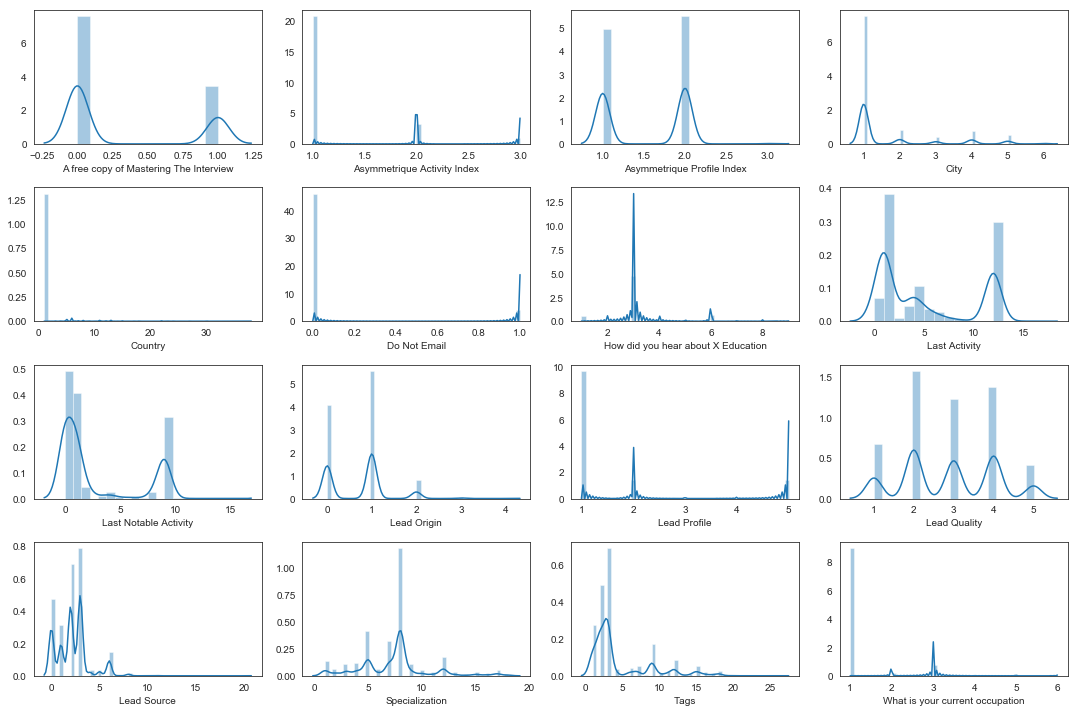

In [85]:
plt.figure(figsize=(15,10))
i=1
while i<=16: 
    plt.subplot(4,4,i)           
    ax= sns.distplot(df_lead_p1[CatVar[i-1]])

    i+=1
plt.tight_layout()

#### Visuzalize Conversion Rate against Categorical Fields

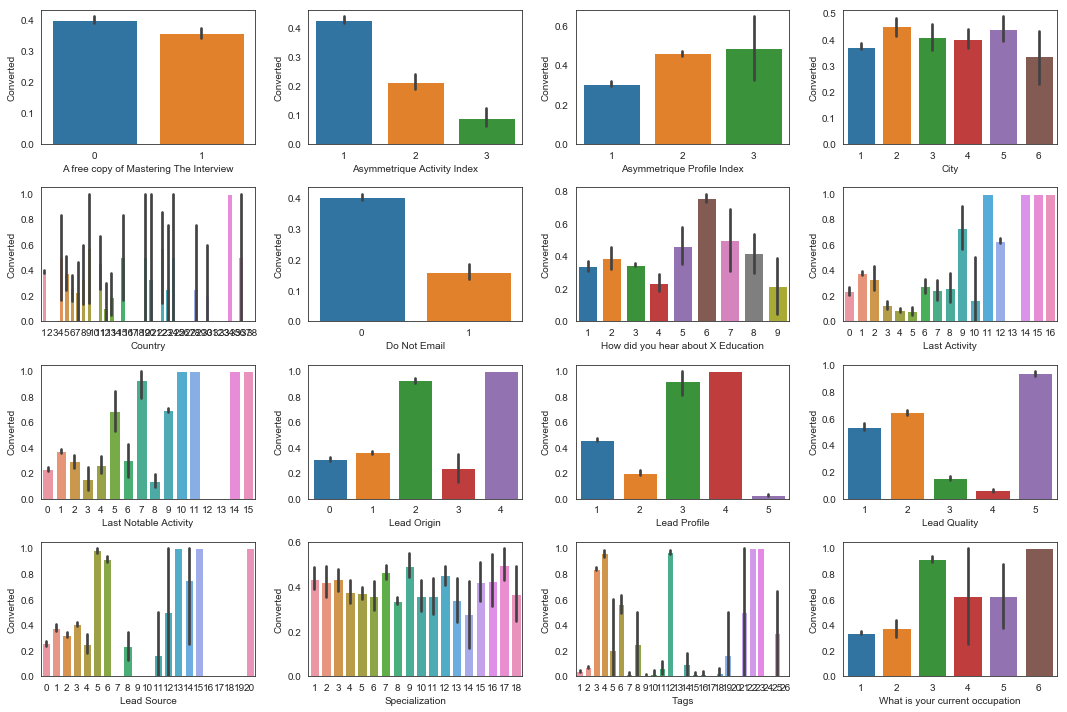

In [86]:
plt.figure(figsize=(15,10))
i=1
while i<=16: 
    plt.subplot(4,4,i)           
    ax= sns.barplot(x=df_lead_p1[CatVar[i-1]],y=df_lead_p1.Converted)

    i+=1
plt.tight_layout()

#### Visualize the Distribution of Numerical Fields

In [87]:
num_flds2

['TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score']

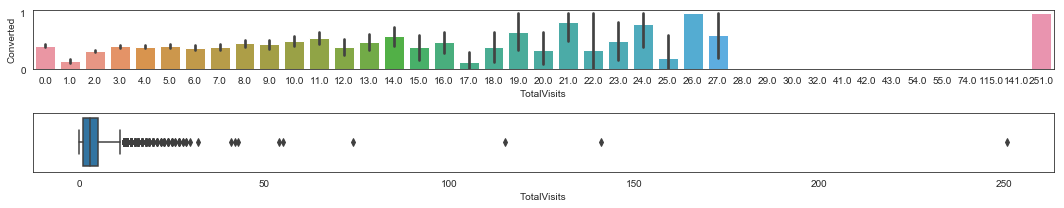

In [88]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
sns.barplot(x=df_lead_p1.TotalVisits, y=df_lead_p1.Converted)
plt.subplot(2,1,2)
sns.boxplot( df_lead_p1['TotalVisits'] )
plt.tight_layout()
plt.show()

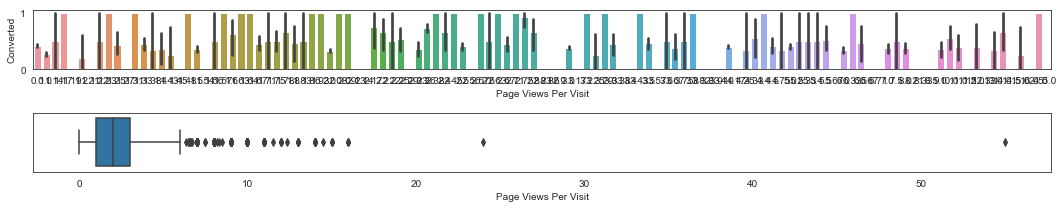

In [89]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
sns.barplot(x=df_lead_p1['Page Views Per Visit'], y=df_lead_p1.Converted)
plt.subplot(2,1,2)
sns.boxplot( df_lead_p1['Page Views Per Visit'] )
plt.tight_layout()
plt.show()

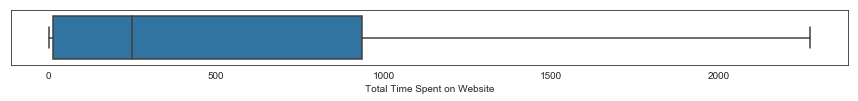

In [90]:
plt.figure(figsize=(15,1))
sns.boxplot( df_lead_p1['Total Time Spent on Website'] )
#sns.barplot(x=df_lead_p1['Total Time Spent on Website'], y=df_lead_p1.Converted)
plt.show()

In [91]:
#"Asymmetrique Profile Score" & "Asymmetrique Activity Score" had 45% Null values
#Therefore let us compare pre-post null treatment data distribution

##### Distribution of data in Asymmetrique Activity Score before null treatment

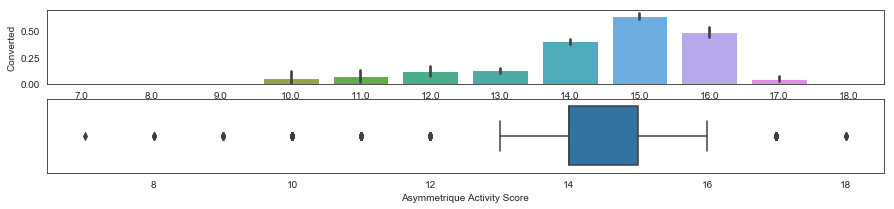

In [92]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
sns.barplot(x=df_lead_org['Asymmetrique Activity Score'], y=df_lead_org.Converted)
plt.subplot(2,1,2)
sns.boxplot( df_lead_org['Asymmetrique Activity Score'] )
plt.show()

##### Distribution of data in Asymmetrique Activity Score After null treatment

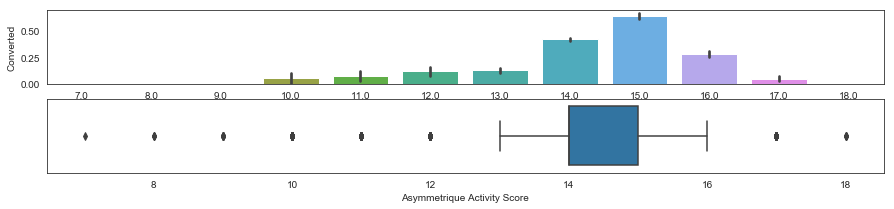

In [93]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
sns.barplot(x=df_lead_p1['Asymmetrique Activity Score'], y=df_lead_p1.Converted)
plt.subplot(2,1,2)
sns.boxplot( df_lead_p1['Asymmetrique Activity Score'] )
plt.show()

##### Distribution of data in Asymmetrique Profile Score before null treatment

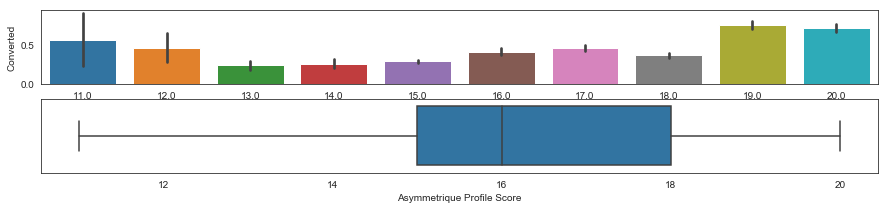

In [94]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
sns.barplot(x=df_lead_org['Asymmetrique Profile Score'], y=df_lead_org.Converted)
plt.subplot(2,1,2)
sns.boxplot( df_lead_org['Asymmetrique Profile Score'] )
plt.show()

##### Distribution of data in Asymmetrique Profile Score After null treatment

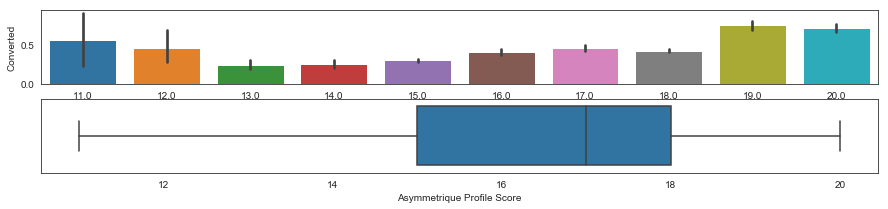

In [95]:
plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
sns.barplot(x=df_lead_p1['Asymmetrique Profile Score'], y=df_lead_p1.Converted)
plt.subplot(2,1,2)
sns.boxplot( df_lead_p1['Asymmetrique Profile Score'] )
plt.show()

##### Correlation Between Different Variables

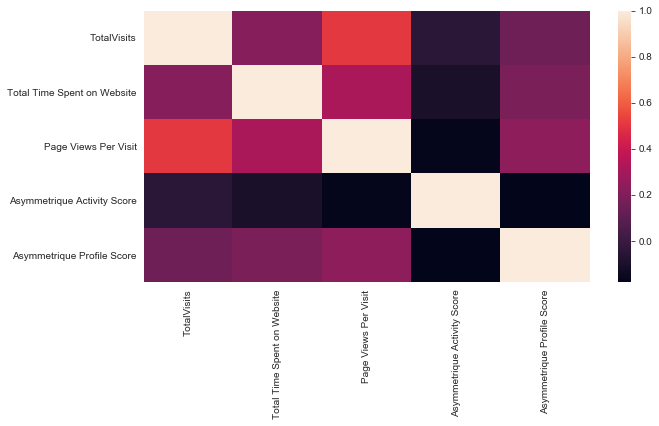

In [96]:
plt.figure(figsize = (10,5))
sns.heatmap(np.round(df_lead_p1[num_flds2].corr(),2))
plt.show()

#### Create Dummy Fields for These Null Treated Categorical Fields

In [97]:
catf=list(getCatFields(df_lead).Categorical_FieldName)
print (catf)

['A free copy of Mastering The Interview', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'City', 'Country', 'Do Not Email', 'How did you hear about X Education', 'Last Activity', 'Last Notable Activity', 'Lead Origin', 'Lead Profile', 'Lead Quality', 'Lead Source', 'Specialization', 'Tags', 'What is your current occupation']


In [98]:
catf_pref= ['free',
 'ActInd',
 'ProInd',
 'City',
 'Cntry',
 'NoEmail',
 'Hear',
 'LastAct',
 'NotableAct',
 'LeadOrg',
 'LeadPro',
 'LeadQ',
 'LeadSrc',
 'Spec',
 'Tags',
 'Occu']

In [99]:
#create dummy fields for all fields in catf, drop the field from df_lead_p2 and contatenate with dummy fields.

i=0
while i < len(catf):
    cat1 = pd.get_dummies(df_lead_p2[ catf[i] ] , prefix=catf_pref[i], drop_first=True)
    df_lead_p2.drop(columns=catf[i], inplace=True)

    #concatenate all the dummy variables with main dataset
    df_lead_p2 = pd.concat( [df_lead_p2,cat1], axis=1)

    i+=1

## Prediction Modeling

In [100]:
numflds_2scale=['TotalVisits',  'Total Time Spent on Website',  'Page Views Per Visit',  
'Asymmetrique Activity Score',  'Asymmetrique Profile Score']

In [101]:
#Train Test Split

X_data=df_lead_p2.drop(columns=["Converted"])
y_data=df_lead_p2.Converted

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=.30, random_state=42 )

#Scale Numberical Fields
sc = StandardScaler()

temp = pd.DataFrame( sc.fit_transform(X_train [numflds_2scale]),columns=numflds_2scale, index=X_train.index )
X_train[numflds_2scale]= temp

temp = pd.DataFrame( sc.fit_transform(X_test [numflds_2scale]),columns=numflds_2scale, index=X_test.index )
X_test[numflds_2scale]= temp


Lead_Number_Train = X_train["Lead Number"]
Lead_Number_Test  = X_test["Lead Number"]

X_train.drop(columns=["Lead Number"], inplace=True)
X_test.drop(columns=["Lead Number"], inplace=True)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Prediction Using PCA

In [102]:
pca = PCA(svd_solver="randomized",random_state=100)

In [103]:
pca_scaled_train = pca.fit_transform(X_train)
pca_scaled_train = pd.DataFrame(pca_scaled_train, columns=X_train.columns)

pca_scaled_test = pca.fit_transform(X_test)
pca_scaled_test = pd.DataFrame(pca_scaled_test, columns=X_test.columns)

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

X_train_pca =X_train.loc [:: ,list(var<=96) ]
X_test_pca  =X_test.loc [:: ,list(var<=96) ]

In [104]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

model_pca = lr.fit(X_train_pca,y_train)

#predict using train data
predictions_train = model_pca.predict(X_train_pca)

#predict using test data
predictions_test_pca = model_pca.predict(X_test_pca)

In [105]:
print ("Accuracy on Train Dataset :",
round(metrics.accuracy_score(y_train, predictions_train),2))

Accuracy on Train Dataset : 0.74


In [106]:
print ("Accuracy on Test Dataset :",
       round(metrics.accuracy_score(y_test, predictions_test_pca),2))

Accuracy on Test Dataset : 0.74


In [107]:
metrics.confusion_matrix(y_train, predictions_train)

array([[3433,  551],
       [1141, 1343]], dtype=int64)

In [108]:
metrics.confusion_matrix(y_test, predictions_test_pca)

array([[1461,  234],
       [ 495,  582]], dtype=int64)

## Prediction Using RFE Method

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
log_model = LogisticRegression()
rfe = RFE(log_model,15)

In [110]:
# Fit the model
rfe =rfe.fit(X_train, y_train)


# make predictions
predictions_train = rfe.predict( X_train )
predictions_test_rfe = rfe.predict( X_test )

In [111]:
print ("Accuracy on Train Dataset :",
round(metrics.accuracy_score(y_train, predictions_train),2))

Accuracy on Train Dataset : 0.91


In [112]:
print ("Accuracy on Test Dataset :",
       round(metrics.accuracy_score(y_test, predictions_test_rfe),2))

Accuracy on Test Dataset : 0.91


In [113]:
metrics.confusion_matrix(y_train, predictions_train)

array([[3580,  404],
       [ 209, 2275]], dtype=int64)

In [114]:
metrics.confusion_matrix(y_test, predictions_test_rfe)

array([[1532,  163],
       [  84,  993]], dtype=int64)

In [115]:
rfe_flds = list(X_train.loc[::,rfe.support_].columns)
rfe_flds

['NotableAct_9',
 'LeadPro_3',
 'LeadPro_5',
 'LeadQ_5',
 'LeadSrc_5',
 'Tags_3',
 'Tags_4',
 'Tags_6',
 'Tags_7',
 'Tags_8',
 'Tags_9',
 'Tags_12',
 'Tags_23',
 'Tags_25',
 'Occu_3']

## Prediction using Statsmodel

In [116]:
# Importing statsmodels for creating model
import statsmodels.api as sm

# Import variance_inflation_factor To calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [117]:
X_train = X_train[rfe_flds]

In [118]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1630.9
Date:                Mon, 26 Aug 2019   Deviance:                       3261.8
Time:                        20:12:32   Pearson chi2:                 6.33e+03
No. Iterations:                    23   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.1099      0.090    -34.413      0.000      -3.287      -2.933
NotableAct_9     1.2379      0.105     11.766      0.000       1.032       1.444
LeadPro_3        2.9734      1.139      2.611      0.009       0.741       5.205
LeadPro_5       -1.0099      0.328     -3.077      0.002      -1.653      -0.367
LeadQ_5          1.7864      0.239      7.460      0.000       1.317       2.256
LeadSrc_5       22.3565    1.4e+04      0.002      0.999   -2.74e+04    2.75e+04
Tags_3           3.9190      0.104     37.809      0.000       3.716       4.122
Tags_4           6.1079      0.430     14.196      0.000       5.265       6.951
Tags_6           2.6716      0.206     12.963      0.000       2.268       3.076
Tags_7          -1.8827      0.720     -2.616      0.009      -3.293      -0.472
Tags_8           2.0633      0.699      2.953      0.003       0.694       3.433
Tags_9          -1.2653      0.469     -2.699      0.007      -2.184      -0.346
Tags_12          5.6208      0.402     13.971      0.000       4.832       6.409
Tags_23         26.1468   6.36e+04      0.000      1.000   -1.25e+05    1.25e+05
Tags_25          2.3397      0.976      2.397      0.017       0.427       4.252
Occu_3           1.9193      0.231      8.312      0.000       1.467       2.372
================================================================================
"""

In [119]:
#drop LeadSrc_5, as this has high p-value
X_train.drop(columns="LeadSrc_5", inplace=True )

In [120]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6453
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1639.4
Date:                Mon, 26 Aug 2019   Deviance:                       3278.8
Time:                        20:12:32   Pearson chi2:                 6.43e+03
No. Iterations:                    20   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.1157      0.090    -34.431      0.000      -3.293      -2.938
NotableAct_9     1.2563      0.105     11.979      0.000       1.051       1.462
LeadPro_3        2.9768      1.139      2.613      0.009       0.744       5.210
LeadPro_5       -1.0093      0.329     -3.068      0.002      -1.654      -0.364
LeadQ_5          1.8369      0.237      7.737      0.000       1.372       2.302
Tags_3           3.9446      0.104     38.085      0.000       3.742       4.148
Tags_4           6.1232      0.430     14.236      0.000       5.280       6.966
Tags_6           2.6692      0.206     12.938      0.000       2.265       3.074
Tags_7          -1.8889      0.720     -2.624      0.009      -3.300      -0.478
Tags_8           2.0669      0.699      2.956      0.003       0.697       3.437
Tags_9          -1.2598      0.469     -2.686      0.007      -2.179      -0.341
Tags_12          5.6940      0.401     14.183      0.000       4.907       6.481
Tags_23         23.1286   1.42e+04      0.002      0.999   -2.78e+04    2.78e+04
Tags_25          2.3363      0.979      2.387      0.017       0.418       4.255
Occu_3           1.9018      0.232      8.198      0.000       1.447       2.356
================================================================================
"""

In [121]:
#drop Tags_23, as this has high p-value
X_train.drop(columns="Tags_23", inplace=True )

In [122]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1646.1
Date:                Mon, 26 Aug 2019   Deviance:                       3292.1
Time:                        20:12:32   Pearson chi2:                 6.42e+03
No. Iterations:                     8   Covariance Type:             nonrobust
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.1018      0.090    -34.510      0.000      -3.278      -2.926
NotableAct_9     1.2807      0.105     12.242      0.000       1.076       1.486
LeadPro_3        2.9688      1.138      2.609      0.009       0.738       5.199
LeadPro_5       -1.0175      0.328     -3.098      0.002      -1.661      -0.374
LeadQ_5          1.8618      0.237      7.857      0.000       1.397       2.326
Tags_3           3.9230      0.103     38.124      0.000       3.721       4.125
Tags_4           6.1101      0.430     14.208      0.000       5.267       6.953
Tags_6           2.6443      0.206     12.823      0.000       2.240       3.048
Tags_7          -1.9192      0.720     -2.666      0.008      -3.330      -0.509
Tags_8           2.0505      0.700      2.931      0.003       0.679       3.422
Tags_9          -1.2716      0.469     -2.713      0.007      -2.190      -0.353
Tags_12          5.6747      0.401     14.142      0.000       4.888       6.461
Tags_25          2.3179      0.980      2.364      0.018       0.396       4.239
Occu_3           1.8978      0.232      8.196      0.000       1.444       2.352
================================================================================
"""

In [123]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test[ X_train.columns])
X_data_sm = sm.add_constant(X_data[ X_train.columns])

logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial()).fit()


predictions_train= logm.predict(X_train_sm)
predictions_test_stats= logm.predict(X_test_sm)
predictions_all = logm.predict(X_data_sm)

## Model Comparision

In [124]:
df_train_pred = pd.DataFrame({'Converted':y_train.values, 'Probablity':predictions_train})
df_test_pred = pd.DataFrame({'Converted':y_test.values, 'Probablity':predictions_test_stats})
df_all_pred = pd.DataFrame({'Converted':y_data.values, 'Probablity':predictions_all})

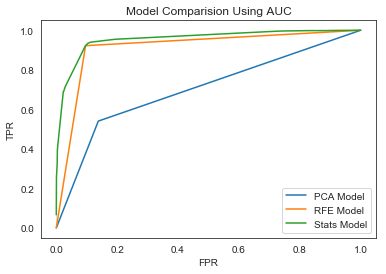

In [125]:
fpr1, tpr1, threshold1 = metrics.roc_curve(df_test_pred.Converted, predictions_test_pca)
fpr2, tpr2, threshold2 = metrics.roc_curve(df_test_pred.Converted, predictions_test_rfe)
fpr3, tpr3, threshold3 = metrics.roc_curve(df_test_pred.Converted, predictions_test_stats)

ax=sns.lineplot(x=fpr1, y=tpr1)
ax=sns.lineplot(x=fpr2, y=tpr2)
ax=sns.lineplot(x=fpr3, y=tpr3)
ax.set_ylabel("TPR")
ax.set_xlabel("FPR")

plt.title("Model Comparision Using AUC")

plt.legend(["PCA Model","RFE Model", "Stats Model"])
plt.show()

#### Fom Above ROC Curves It looks Model Using StatusModel Algorithm is the best suited for our Problem

## Metrics & Evaluation

#### We will see the metrics on Train & Test Dataset Using StatsModel

In [126]:
def plot_CutOffCurve(df_CutOff):
    plt.figure(figsize=(15,5))
    ax=sns.lineplot(x="Cut_off", y="Accuracy", data=df_CutOff)
    ax=sns.lineplot(x="Cut_off", y="Recall", data=df_CutOff)
    ax=sns.lineplot(x="Cut_off", y="Precision", data=df_CutOff)
    ax=sns.lineplot(x="Cut_off", y="Specificity", data=df_CutOff)
    ax=sns.lineplot(x="Cut_off", y="Error_Rate", data=df_CutOff)
    ax=sns.lineplot(x="Cut_off", y="FNR", data=df_CutOff)
    ax=sns.lineplot(x="Cut_off", y="FPR", data=df_CutOff)
    ax.set_ylabel("Probability")
    plt.legend(["Accuracy","Recall", "Precision", "Specificity", "Error_Rate", "FNR", "FPR"])

    ax.set_title ( "Cut-Off Curve")
    ax.set_xticks(ticks=[.1,.15,.2,.3,.4,.5,.6,.65,.7,.8,.9])
    plt.show()

In [127]:
def getCutOff_data(df): 
    cutoff=.1
    cut_matrix=[]
    while cutoff<=.99:
        df['predicted'] = df.Probablity.map(lambda x: 1 if x > cutoff else 0)
        cm = metrics.confusion_matrix(df.Converted, df.predicted)

        cut_matrix.append( [ round(cutoff,2), list(cm)])
        cutoff+=.05


    mat1=[]
    mat2=[]
    for i in cut_matrix:
        TN=i[1][0][0]
        FP=i[1][0][1]
        FN=i[1][1][0]
        TP=i[1][1][1]
        Tot= TN+FP+FN+TP

        acc = round( (TN+TP)/Tot, 2)
        recall = round( TP/(TP+FN), 2)
        prec = round( TP / (TP +FP), 2)
        spec = round( TN / (TN+FP), 2)
        err = round( 1-acc, 2)
        fpr = round( 1-spec, 2)
        fnr = round( 1-recall, 2)
        mat1.append( [i[0], acc, recall, prec, spec, err, fnr, fpr])


    df_CutOff = pd.DataFrame( mat1, columns=["Cut_off","Accuracy", "Recall", "Precision", "Specificity", "Error_Rate", "FNR", "FPR"])

    return df_CutOff

## Train Dataset

In [128]:
df_CutOff = getCutOff_data(df_train_pred)
df_CutOff

,Cut_off,Accuracy,Recall,Precision,Specificity,Error_Rate,FNR,FPR
0,0.10,0.86,0.95,0.75,0.80,0.14,0.05,0.20
1,0.15,0.90,0.93,0.82,0.88,0.10,0.07,0.12
2,0.20,0.90,0.93,0.82,0.88,0.10,0.07,0.12
3,0.25,0.90,0.93,0.84,0.89,0.10,0.07,0.11
4,0.30,0.91,0.93,0.84,0.89,0.09,0.07,0.11
5,0.35,0.91,0.93,0.84,0.89,0.09,0.07,0.11
6,0.40,0.91,0.92,0.85,0.90,0.09,0.08,0.10
7,0.45,0.91,0.92,0.85,0.90,0.09,0.08,0.10
8,0.50,0.91,0.92,0.85,0.90,0.09,0.08,0.10
9,0.55,0.91,0.92,0.85,0.90,0.09,0.08,0.10


In [129]:
#At Cut off 65% We are getting best result

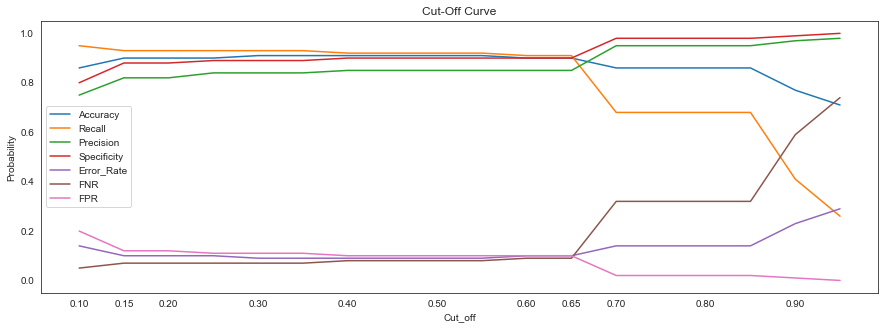

In [130]:
plot_CutOffCurve(df_CutOff)

## Test Dataset

In [131]:
df_CutOff=getCutOff_data(df_test_pred)
df_CutOff

,Cut_off,Accuracy,Recall,Precision,Specificity,Error_Rate,FNR,FPR
0,0.10,0.86,0.95,0.76,0.81,0.14,0.05,0.19
1,0.15,0.91,0.94,0.84,0.89,0.09,0.06,0.11
2,0.20,0.91,0.94,0.84,0.89,0.09,0.06,0.11
3,0.25,0.91,0.94,0.85,0.89,0.09,0.06,0.11
4,0.30,0.91,0.94,0.85,0.90,0.09,0.06,0.10
5,0.35,0.91,0.94,0.85,0.90,0.09,0.06,0.10
6,0.40,0.91,0.92,0.86,0.90,0.09,0.08,0.10
7,0.45,0.91,0.92,0.86,0.90,0.09,0.08,0.10
8,0.50,0.91,0.92,0.86,0.90,0.09,0.08,0.10
9,0.55,0.91,0.92,0.86,0.90,0.09,0.08,0.10


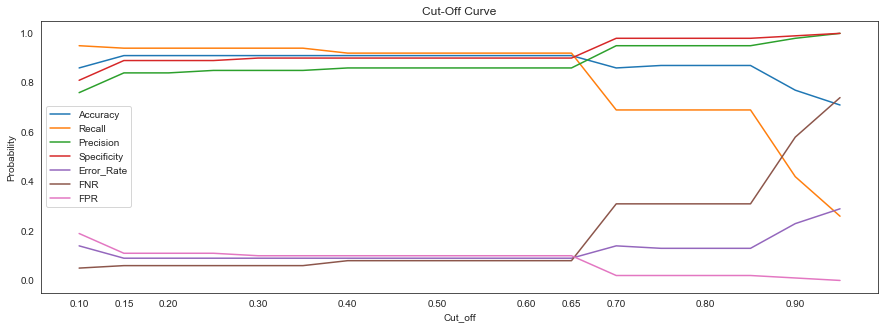

In [132]:
plot_CutOffCurve(df_CutOff)

In [133]:
#For Test dataset
cutoff=.65
df_test_pred['predicted'] = df_test_pred.Probablity.map(lambda x: 1 if x > cutoff else 0)
cm = metrics.confusion_matrix(df_test_pred.Converted, df_test_pred.predicted)
cm

array([[1533,  162],
       [  85,  992]], dtype=int64)

In [134]:
#For whole dataset
cutoff=.65
df_all_pred['predicted'] = df_all_pred.Probablity.map(lambda x: 1 if x > cutoff else 0)
cm = metrics.confusion_matrix(df_all_pred.Converted, df_all_pred.predicted)
cm

array([[5114,  565],
       [ 297, 3264]], dtype=int64)

In [135]:
print ("Area Uncer Curve (AUC) for Whole Dataset Using Stats Model", 
       round(metrics.roc_auc_score(df_all_pred.Converted, df_all_pred.predicted),2))

Area Uncer Curve (AUC) for Whole Dataset Using Stats Model 0.91


In [136]:
print ("Area Uncer Curve (AUC) for Test Dataset Using Stats Model", 
       round(metrics.roc_auc_score(df_test_pred.Converted, df_test_pred.predicted),2))

Area Uncer Curve (AUC) for Test Dataset Using Stats Model 0.91


In [137]:
#Print Lead Score for Leads Cut-off =.65
df_test_pred['Lead_Score'] = (df_test_pred['Probablity']*100).astype(int)
df_test_pred.merge(pd.DataFrame(Lead_Number_Test), how="inner", left_index=True, right_index=True).head()


,Converted,Probablity,predicted,Lead_Score,Lead Number
4608,1,0.929096,1,92,615582
7935,0,0.004537,0,0,588939
4043,0,0.015996,0,1,621242
7821,0,0.230766,0,23,589803
856,0,0.043034,0,4,651441


### Identifying Important Variables

In [138]:
def getVIF():
    vif = pd.DataFrame()
    X = X_train
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print (vif)
    return vif

In [139]:
vif=getVIF()

        Features   VIF
6         Tags_6  1.03
1      LeadPro_3  1.02
7         Tags_7  1.02
5         Tags_4  1.01
8         Tags_8  1.00
11       Tags_25  1.00
3        LeadQ_5  0.68
12        Occu_3  0.57
2      LeadPro_5  0.40
0   NotableAct_9  0.23
4         Tags_3  0.14
9         Tags_9  0.08
10       Tags_12  0.02


In [140]:
list(vif.Features.sort_values())

['LeadPro_3',
 'LeadPro_5',
 'LeadQ_5',
 'NotableAct_9',
 'Occu_3',
 'Tags_12',
 'Tags_25',
 'Tags_3',
 'Tags_4',
 'Tags_6',
 'Tags_7',
 'Tags_8',
 'Tags_9']

In [141]:
#5 Important Fields from Dataset Which are important for Prediction are
#Lead Profile
#Lead Quality
#Last Notable Activity
#Occupation
#Tags